<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Lo que hicimos...

Empezamos probando LeNet. Sabiamos que el resultado no iba a ser el mejor pero quisimos probar hasta donde podiamos llegar haciendole algunas modificaciones.

Luego de esto decidimos utilizar DenseNet.
Probamos correrla con su arquitectura original y los resultados fueron mucho mejores, notando grandes diferencias simplemente modificando batch_size e image_size

# Librerias y definiciones

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
)

In [3]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [5]:
BATCH_SIZE = 128  # tamaño del batch
NUM_CLASES = 10   # cantidad de clases en Imagenette

# Exploracion de datos

## Carga de datos

Cargamos los datos de train, sin transformaciones, para explorar los datos.

In [6]:
DATA_DIR = Path("data")

imagenette_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [7]:
name_classes = imagenette_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

In [8]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images
    print(f"{cls}: {n_images} imágenes")

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")


n03425413: 931 imágenes
n01440764: 963 imágenes
n02979186: 993 imágenes
n03888257: 960 imágenes
n03000684: 858 imágenes
n03445777: 951 imágenes
n02102040: 955 imágenes
n03028079: 941 imágenes
n03394916: 956 imágenes
n03417042: 961 imágenes

Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

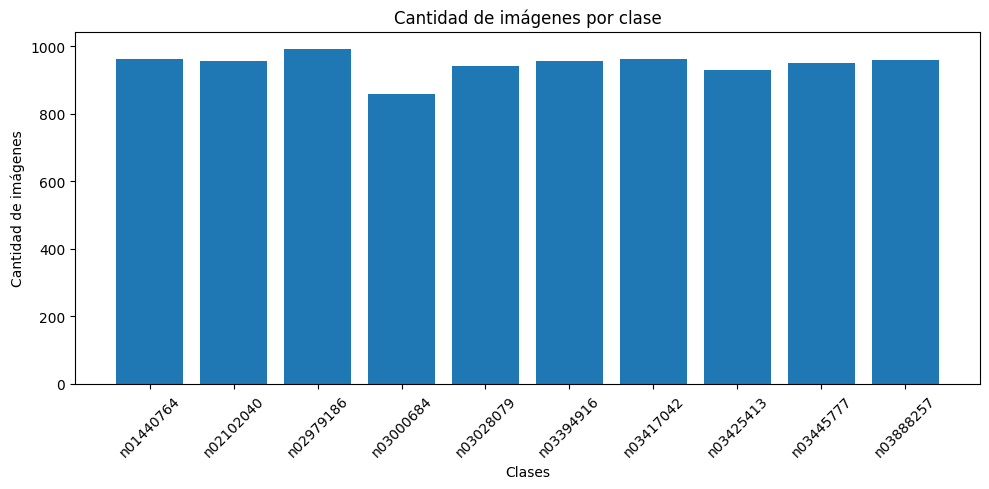

In [9]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

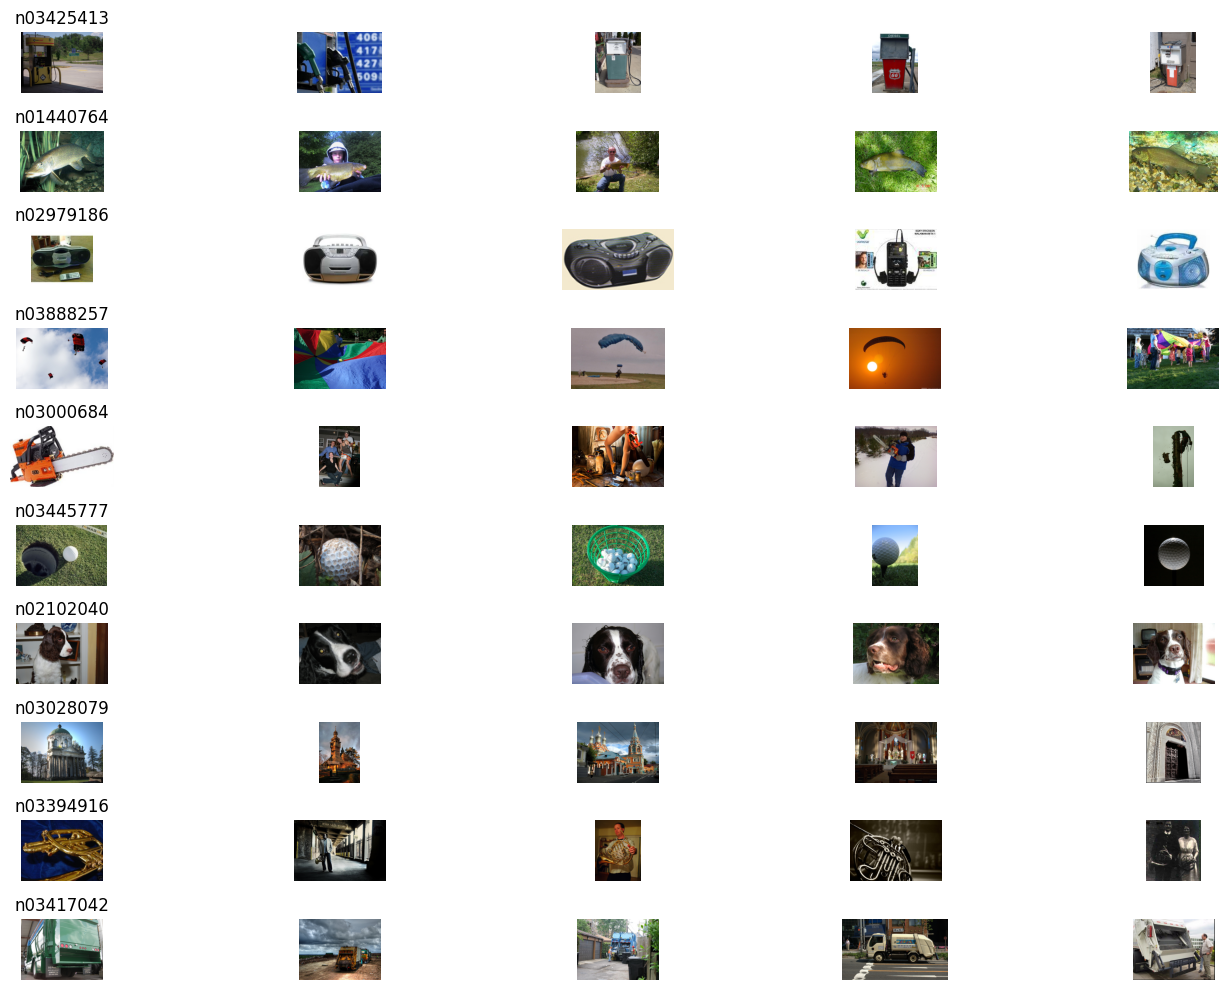

In [10]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [11]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 226
Tamaño MÁS común: (500, 375) (aparece 112 veces)
Tamaño MENOS común: (470, 500) (aparece 1 veces)


## Buscar duplicados

In [12]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


## Conclusión de la exploracion de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# LeNet

## Definiciones

In [13]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria
IMG_SIZE = 32    # para LeNet original 

## Carga de datos con transforms para LeNet

In [14]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset CIFAR10 (si no lo tenemos ya)
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [15]:
# train dataset con transformaciones base para calcular media y desviacion
train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.Grayscale(num_output_channels=1),
    ])
) 

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([0.4561])
Std: tensor([0.2516])


In [16]:
train_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10), 
    T.Grayscale(num_output_channels=1),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
    T.Grayscale(num_output_channels=1),
])

## Regularization

### Data Augmentation
Aplicado en transformaciones sobre train

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [17]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        """
        LeNet clasica con opción de dropout
        """
        
        super(LeNet, self).__init__()

        self.use_dropout = use_dropout
        self.dropout_p = dropout_p
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)

        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        x = self.flatten(x)
        x = self.tanh(self.linear(x))
        x = self.dropout(x) # despues de la activacion
        x = self.output(x)
        return x


summary(LeNet(1, NUM_CLASES), input_size=(BATCH_SIZE, 1, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 28, 28]           156
├─Tanh: 1-2                              [32, 6, 28, 28]           --
├─AvgPool2d: 1-3                         [32, 6, 14, 14]           --
├─Conv2d: 1-4                            [32, 16, 10, 10]          2,416
├─Tanh: 1-5                              [32, 16, 10, 10]          --
├─AvgPool2d: 1-6                         [32, 16, 5, 5]            --
├─Conv2d: 1-7                            [32, 120, 1, 1]           48,120
├─Tanh: 1-8                              [32, 120, 1, 1]           --
├─Flatten: 1-9                           [32, 120]                 --
├─Linear: 1-10                           [32, 84]                  10,164
├─Tanh: 1-11                             [32, 84]                  --
├─Identity: 1-12                         [32, 84]                  --
├─L

## Entrenamiento


In [18]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [19]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)

In [20]:
letnet_model = LeNet(1,NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    do_early_stopping=True,
    patience=10,
    epochs=EPOCHS,
    log_fn=print_log,
    log_every=1,
)

Epoch: 001 | Train Loss: 2.11482 | Val Loss: 2.04609
Epoch: 002 | Train Loss: 2.06137 | Val Loss: 2.02734
Epoch: 003 | Train Loss: 2.02272 | Val Loss: 1.98300
Epoch: 004 | Train Loss: 1.97927 | Val Loss: 1.95126
Epoch: 005 | Train Loss: 1.93522 | Val Loss: 1.93337
Epoch: 006 | Train Loss: 1.89185 | Val Loss: 1.89705
Epoch: 007 | Train Loss: 1.84800 | Val Loss: 1.86270
Epoch: 008 | Train Loss: 1.80511 | Val Loss: 1.84096
Epoch: 009 | Train Loss: 1.75497 | Val Loss: 1.82782
Epoch: 010 | Train Loss: 1.70870 | Val Loss: 1.80214
Epoch: 011 | Train Loss: 1.66667 | Val Loss: 1.78237
Epoch: 012 | Train Loss: 1.63456 | Val Loss: 1.77444
Epoch: 013 | Train Loss: 1.58328 | Val Loss: 1.77630
Epoch: 014 | Train Loss: 1.55033 | Val Loss: 1.77892
Epoch: 015 | Train Loss: 1.51114 | Val Loss: 1.77492
Epoch: 016 | Train Loss: 1.48734 | Val Loss: 1.75845
Epoch: 017 | Train Loss: 1.45175 | Val Loss: 1.77287
Epoch: 018 | Train Loss: 1.41631 | Val Loss: 1.80915
Epoch: 019 | Train Loss: 1.39523 | Val Loss: 1

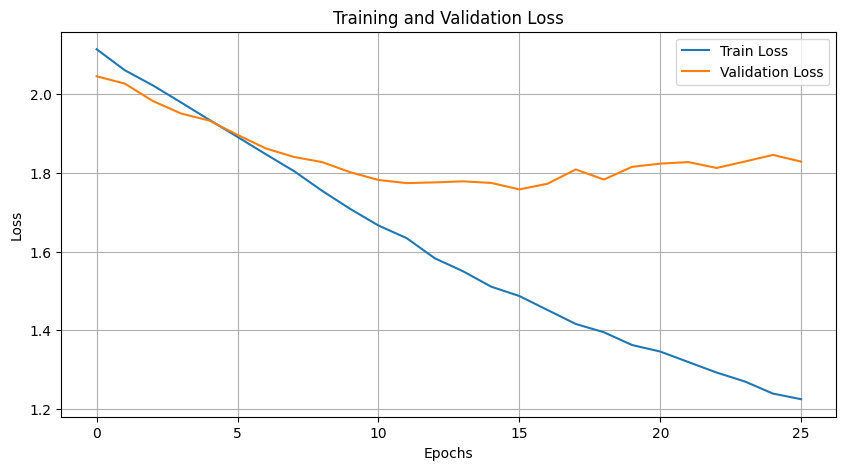

In [22]:
plot_training(epoch_train_errors, epoch_val_errors)

In [24]:
model_classification_report(letnet_model, val_loader, DEVICE, nclasses)

Accuracy: 0.4102

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       193
           1       0.38      0.54      0.44       205
           2       0.50      0.45      0.48       204
           3       0.32      0.15      0.21       156
           4       0.38      0.40      0.39       188
           5       0.31      0.31      0.31       192
           6       0.43      0.44      0.44       198
           7       0.34      0.32      0.33       184
           8       0.36      0.40      0.38       186
           9       0.54      0.55      0.55       188

    accuracy                           0.41      1894
   macro avg       0.41      0.40      0.40      1894
weighted avg       0.41      0.41      0.41      1894



## Weight & Biases

In [26]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_3"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

True

In [27]:
sweep_config = {
    "name": "tarea_1_lenet",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data
        "batch_size": {"values": [32, 64, 128]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [3, 8]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: da8kuc8y
Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_3/sweeps/da8kuc8y


In [28]:
import time 

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing

    # modelo
    if run_dropout_p == 0:
        model = LeNet(1,10).to(DEVICE)
    else:
        model = LeNet(1,10,True,run_dropout_p).to(DEVICE)

    # dataloaders  
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 10 == 0:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)         

    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    wandb.finish()

In [29]:
print("DEVICE = ", DEVICE)

DEVICE =  cuda


In [30]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: y90bfzpo with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0036072519087987738
wandb: 	optimizer: adam
wandb: 	patience: 8
wandb: 	weight_decay: 0.0001


[EPOCH 10] train_loss=1.7643 val_loss=1.8335
[EPOCH 20] train_loss=1.5239 val_loss=1.7975
Detener entrenamiento en la época 28, la mejor pérdida fue 1.77463


epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,20
train_loss,1.52389
val_loss,1.79754


wandb: Agent Starting Run: 6pbwuv29 with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0007283939421952476
wandb: 	optimizer: adam
wandb: 	patience: 8
wandb: 	weight_decay: 0


[EPOCH 10] train_loss=1.8188 val_loss=1.8923
[EPOCH 20] train_loss=1.5774 val_loss=1.7984
Detener entrenamiento en la época 26, la mejor pérdida fue 1.77679


epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,20
train_loss,1.57743
val_loss,1.7984


wandb: Agent Starting Run: wmpyu4oj with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.002866956929347663
wandb: 	optimizer: adam
wandb: 	patience: 8
wandb: 	weight_decay: 0.0005


[EPOCH 10] train_loss=1.7552 val_loss=1.8429
[EPOCH 20] train_loss=1.4620 val_loss=1.7690
[EPOCH 30] train_loss=1.2361 val_loss=1.8132
Detener entrenamiento en la época 30, la mejor pérdida fue 1.73888


epoch,▁▅█
train_loss,█▄▁
val_loss,█▁▅
epoch,30
train_loss,1.23614
val_loss,1.81317


wandb: Agent Starting Run: zhveojz0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0005575366738517505
wandb: 	optimizer: sgd
wandb: 	patience: 8
wandb: 	weight_decay: 0.0001


[EPOCH 10] train_loss=2.1176 val_loss=2.1016
[EPOCH 20] train_loss=2.0855 val_loss=2.0710
[EPOCH 30] train_loss=2.0590 val_loss=2.0467
[EPOCH 40] train_loss=2.0245 val_loss=2.0138
[EPOCH 50] train_loss=1.9776 val_loss=1.9781
[EPOCH 60] train_loss=1.9168 val_loss=1.9278
[EPOCH 70] train_loss=1.8503 val_loss=1.8660
[EPOCH 80] train_loss=1.7899 val_loss=1.8208
[EPOCH 90] train_loss=1.7455 val_loss=1.7807
[EPOCH 100] train_loss=1.7030 val_loss=1.7545


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▆▅▃▂▂▁
val_loss,█▇▇▆▆▄▃▂▂▁
epoch,100
train_loss,1.70304
val_loss,1.75453


wandb: Agent Starting Run: jdmrhqyk with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.002858368480303142
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	weight_decay: 0.0001


[EPOCH 10] train_loss=2.0518 val_loss=2.0235
[EPOCH 20] train_loss=1.9356 val_loss=1.9294
[EPOCH 30] train_loss=1.7698 val_loss=1.8034
[EPOCH 40] train_loss=1.6436 val_loss=1.6674
[EPOCH 50] train_loss=1.5455 val_loss=1.6088
Detener entrenamiento en la época 54, la mejor pérdida fue 1.60073


epoch,▁▃▅▆█
train_loss,█▆▄▂▁
val_loss,█▆▄▂▁
epoch,50
train_loss,1.54546
val_loss,1.60884


wandb: Agent Starting Run: gnwqpzat with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00011875898125510468
wandb: 	optimizer: adam
wandb: 	patience: 3
wandb: 	weight_decay: 0.0001


[EPOCH 10] train_loss=1.9914 val_loss=1.9802
[EPOCH 20] train_loss=1.8807 val_loss=1.8968
[EPOCH 30] train_loss=1.7672 val_loss=1.8192
[EPOCH 40] train_loss=1.6687 val_loss=1.7632
[EPOCH 50] train_loss=1.5901 val_loss=1.7309
[EPOCH 60] train_loss=1.5187 val_loss=1.7047
[EPOCH 70] train_loss=1.4532 val_loss=1.7001
[EPOCH 80] train_loss=1.4062 val_loss=1.6905
[EPOCH 90] train_loss=1.3542 val_loss=1.6945
[EPOCH 100] train_loss=1.3028 val_loss=1.7075


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▃▂▂▁
val_loss,█▆▄▃▂▁▁▁▁▁
epoch,100
train_loss,1.30278
val_loss,1.70747


wandb: Agent Starting Run: 5y8a0mej with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.2
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0007951696683732898
wandb: 	optimizer: sgd
wandb: 	patience: 8
wandb: 	weight_decay: 0.0001


[EPOCH 10] train_loss=2.1594 val_loss=2.1452
[EPOCH 20] train_loss=2.1104 val_loss=2.0908
[EPOCH 30] train_loss=2.0933 val_loss=2.0717
[EPOCH 40] train_loss=2.0767 val_loss=2.0588
[EPOCH 50] train_loss=2.0645 val_loss=2.0479
[EPOCH 60] train_loss=2.0566 val_loss=2.0368
[EPOCH 70] train_loss=2.0382 val_loss=2.0252
[EPOCH 80] train_loss=2.0262 val_loss=2.0088
[EPOCH 90] train_loss=2.0113 val_loss=1.9944
[EPOCH 100] train_loss=1.9888 val_loss=1.9763


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▅▄▄▃▃▂▁
val_loss,█▆▅▄▄▄▃▂▂▁
epoch,100
train_loss,1.98881
val_loss,1.97625


wandb: Agent Starting Run: wknn3756 with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0022218225729347305
wandb: 	optimizer: adam
wandb: 	patience: 3
wandb: 	weight_decay: 0.0001


[EPOCH 10] train_loss=1.8198 val_loss=1.8338
[EPOCH 20] train_loss=1.5716 val_loss=1.7865
Detener entrenamiento en la época 22, la mejor pérdida fue 1.78651


epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,20
train_loss,1.5716
val_loss,1.78651


wandb: Agent Starting Run: 2dwui422 with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00017973418295828196
wandb: 	optimizer: adam
wandb: 	patience: 8
wandb: 	weight_decay: 0


[EPOCH 10] train_loss=2.0230 val_loss=2.0144
[EPOCH 20] train_loss=1.8978 val_loss=1.9174
[EPOCH 30] train_loss=1.7833 val_loss=1.8376
[EPOCH 40] train_loss=1.7034 val_loss=1.8041
[EPOCH 50] train_loss=1.6441 val_loss=1.7854
[EPOCH 60] train_loss=1.5796 val_loss=1.7700
[EPOCH 70] train_loss=1.5278 val_loss=1.7602
Detener entrenamiento en la época 78, la mejor pérdida fue 1.75415


epoch,▁▂▃▅▆▇█
train_loss,█▆▅▃▃▂▁
val_loss,█▅▃▂▂▁▁
epoch,70
train_loss,1.52779
val_loss,1.76024


wandb: Agent Starting Run: uvk68bzo with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00024127247974317135
wandb: 	optimizer: sgd
wandb: 	patience: 8
wandb: 	weight_decay: 0


[EPOCH 10] train_loss=2.2180 val_loss=2.2094
[EPOCH 20] train_loss=2.1595 val_loss=2.1521
[EPOCH 30] train_loss=2.1246 val_loss=2.1152
[EPOCH 40] train_loss=2.1070 val_loss=2.0930
[EPOCH 50] train_loss=2.0916 val_loss=2.0773
[EPOCH 60] train_loss=2.0799 val_loss=2.0647
[EPOCH 70] train_loss=2.0705 val_loss=2.0548
[EPOCH 80] train_loss=2.0634 val_loss=2.0471
[EPOCH 90] train_loss=2.0577 val_loss=2.0404
[EPOCH 100] train_loss=2.0497 val_loss=2.0342


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▃▂▂▂▁▁
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,100
train_loss,2.04974
val_loss,2.03423


## Evaluación final tomando mejor modelo

In [31]:
api = wandb.Api()

# ULTIMA CORRIDA
# Create sweep with ID: da8kuc8y
# Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_3/sweeps/da8kuc8y

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
 
# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")
print("\nBest run name:", best_run.name)
print("\nBest run id:", best_run.id)
print("\nBest run config:", best_run.config)
print("\nSUMMARY:",best_run.summary_metrics)

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


Best run stoic-sweep-9 with 1.7602404197057089 2dwui422

Best run name: stoic-sweep-9

Best run id: 2dwui422

Best run config: {'patience': 8, 'dropout_p': 0, 'optimizer': 'adam', 'batch_size': 64, 'early_stop': True, 'weight_decay': 0, 'learning_rate': 0.00017973418295828196, 'label_smoothing': 0.05}

SUMMARY: {'_runtime': 980.187503976, '_step': 6, '_timestamp': 1760299703.773621, '_wandb': {'runtime': 1108}, 'epoch': 70, 'train_loss': 1.5277868719661938, 'val_loss': 1.7602404197057089}


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [32]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 1.71329


In [33]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.4265

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.49      0.56      0.52       387
           1       0.46      0.51      0.48       395
           2       0.44      0.52      0.48       357
           3       0.32      0.17      0.23       386
           4       0.40      0.45      0.43       409
           5       0.30      0.28      0.29       394
           6       0.56      0.47      0.51       389
           7       0.30      0.33      0.31       419
           8       0.42      0.41      0.42       399
           9       0.56      0.57      0.56       390

    accuracy                           0.43      3925
   macro avg       0.42      0.43      0.42      3925
weighted avg       0.42      0.43      0.42      3925



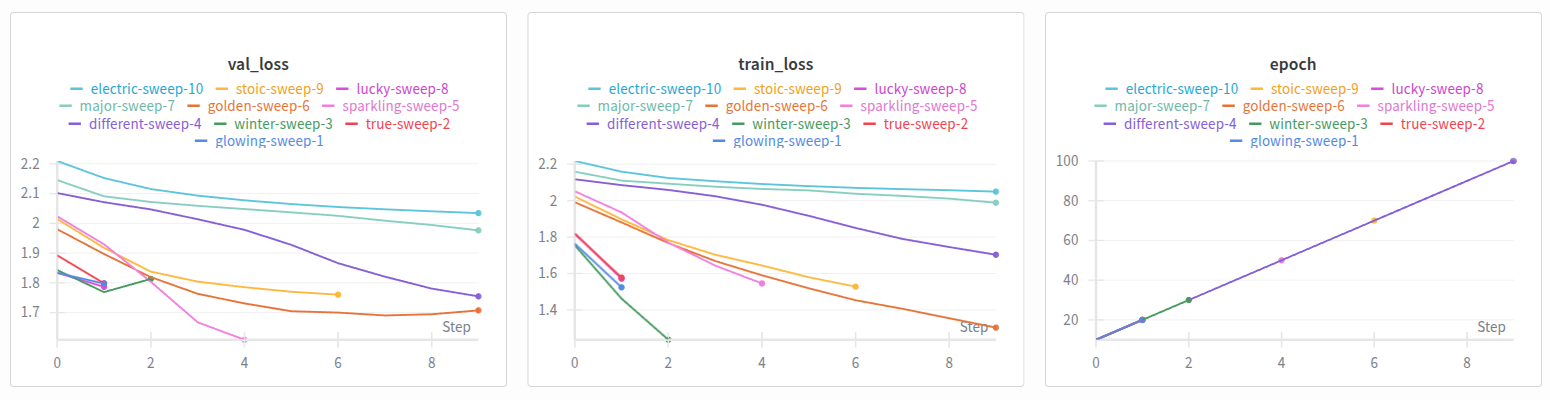

## Conclusión de los datos

# DenseNet

## Definiciones

In [35]:
IMG_SIZE = 128 # image size lo mas grande posible para tener mas resolucion

## Arquitectura

In [36]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

In [37]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [38]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [39]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 128, 128]        128
├─ReLU: 1-3                                   [32, 64, 128, 128]        --
├─Sequential: 1-4                             [32, 1024, 16, 16]        --
│    └─DenseBlock: 2-1                        [32, 256, 128, 128]       --
│    │    └─Sequential: 3-1                   [32, 256, 128, 128]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 128, 128]       512
│    │    └─ReLU: 3-3                         [32, 256, 128, 128]       --
│    │    └─Conv2d: 3-4                       [32, 128, 128, 128]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 64, 64]         --
│    └

## Carga de datos con transforms

In [44]:
train_tfms_densenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),

    # Geométricas
    T.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),

    # Fotométricas que resaltan textura
    T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5),
    T.RandomEqualize(p=0.3),              # si no usas CLAHE
    T.RandomAutocontrast(p=0.3),

    # Invariancia a blur para no sobreajustar a bordes perfectos
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),

    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_densenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


In [45]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_densenet, val_tfms_densenet, BATCH_SIZE, NUM_WORKERS)

## Entrenamiento DenseNet Original

In [46]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 2.11489 | Val Loss: 1.97904
Epoch: 002 | Train Loss: 1.86558 | Val Loss: 1.75006
Epoch: 003 | Train Loss: 1.72256 | Val Loss: 2.25827
Epoch: 004 | Train Loss: 1.62363 | Val Loss: 1.89853
Epoch: 005 | Train Loss: 1.51061 | Val Loss: 1.46079
Epoch: 006 | Train Loss: 1.44385 | Val Loss: 1.44889
Epoch: 007 | Train Loss: 1.35436 | Val Loss: 1.20573
Epoch: 008 | Train Loss: 1.29015 | Val Loss: 1.59382
Epoch: 009 | Train Loss: 1.22554 | Val Loss: 1.14694
Epoch: 010 | Train Loss: 1.13176 | Val Loss: 1.02947
Epoch: 011 | Train Loss: 1.10715 | Val Loss: 1.01747
Epoch: 012 | Train Loss: 1.07388 | Val Loss: 1.16928
Epoch: 013 | Train Loss: 1.00028 | Val Loss: 0.90013
Epoch: 014 | Train Loss: 1.00860 | Val Loss: 1.34850
Epoch: 015 | Train Loss: 0.95402 | Val Loss: 0.77419
Epoch: 016 | Train Loss: 0.91522 | Val Loss: 0.76202
Epoch: 017 | Train Loss: 0.86850 | Val Loss: 0.88324
Epoch: 018 | Train Loss: 0.85913 | Val Loss: 0.82798
Epoch: 019 | Train Loss: 0.83601 | Val Loss: 0

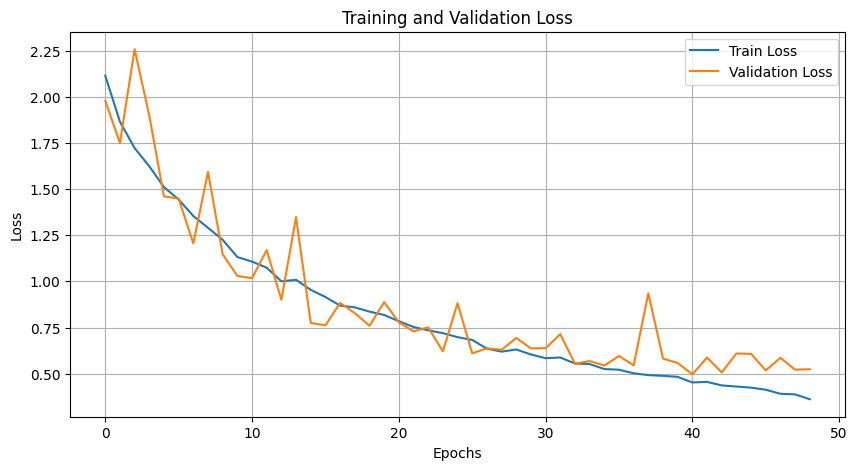

In [49]:
plot_training(train_errors_dn, val_errors_dn)

In [50]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8270

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       387
           1       0.98      0.80      0.88       395
           2       0.68      0.93      0.79       357
           3       0.67      0.68      0.67       386
           4       0.79      0.92      0.85       409
           5       0.85      0.76      0.80       394
           6       0.94      0.79      0.85       389
           7       0.78      0.78      0.78       419
           8       0.88      0.88      0.88       399
           9       0.87      0.86      0.87       390

    accuracy                           0.83      3925
   macro avg       0.84      0.83      0.83      3925
weighted avg       0.84      0.83      0.83      3925



## Entrenamiento DenseNet con cosine decay

In [48]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_cosine_decay(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=print_log,
    log_every=1,
    eta_min=1e-6,
):
    """
    Entrena el modelo utilizando Cosine Decay (CosineAnnealingLR) para el learning rate.
    """

    epoch_train_errors = []
    epoch_val_errors = []

    if do_early_stopping:
        early_stopping = EarlyStopping(patience=patience)

    # Scheduler Cosine Decay
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            
            output = model(x)
            batch_loss = criterion(output, y)
            
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

        train_loss /= len(train_loader)
        epoch_train_errors.append(train_loss)

        val_loss = evaluate(model, criterion, val_loader, device)
        epoch_val_errors.append(val_loss)

        # Step del scheduler (una vez por epoch)
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        if do_early_stopping:
            early_stopping(val_loss)

        if log_fn is not None and (epoch + 1) % log_every == 0:
            log_fn(epoch, train_loss, val_loss)
            print(f"[EPOCH {epoch+1}] lr={current_lr:.6e} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

        if do_early_stopping and early_stopping.early_stop:
            print(f"⏹ Detener entrenamiento en la época {epoch+1}, mejor val_loss={early_stopping.best_score:.5f}")
            break

    return epoch_train_errors, epoch_val_errors


In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

train_errors_dn, val_errors_dn = train_cosine_decay(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

## Weight & Biases

## Conclusión de los datos

# Comparación ambos modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.